In [4]:
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
import os

os.chdir("..")
print(os.getcwd())

synBrainPd_img = nib.load("thayKhoa/datasets/BrainWeb/synBrainPd.mnc")
synBrainT1_img = nib.load("thayKhoa/datasets/BrainWeb/synBrainT1.mnc")
synBrainT2_img = nib.load("thayKhoa/datasets/BrainWeb/synBrainT2.mnc")

E:\Thacsi\Master_Course\ImageDenoise


In [7]:
synBrainPd_data = synBrainPd_img.get_fdata()
synBrainT1_data = synBrainT1_img.get_fdata()
synBrainT2_data = synBrainT2_img.get_fdata()
print(np.max(synBrainPd_data), np.min(synBrainPd_data))
print(np.max(synBrainT1_data), np.min(synBrainPd_data))
print(np.max(synBrainT2_data), np.min(synBrainPd_data))

data = {
    "synBrainPd": synBrainPd_data,
    "synBrainT1": synBrainT1_data,
    "synBrainT2": synBrainT2_data,
}

6135.960817337036 1.5836964426901813e-11
1196.6468393802643 1.5836964426901813e-11
4741.664826869965 1.5836964426901813e-11


(217, 181)


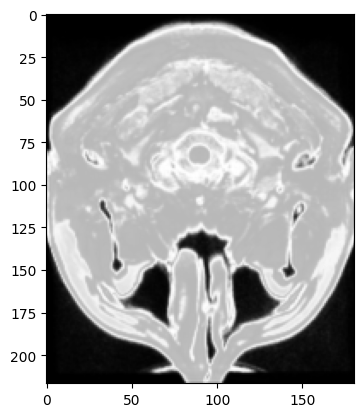

In [6]:
uint8_data = (synBrainPd_data / np.max(synBrainPd_data) * 255).astype(np.uint8)
print(uint8_data[1, :, :].shape)
plt.imshow(uint8_data[1, :, :], cmap="gray")

In [10]:
import os

os.makedirs("data_origin", exist_ok=True)


for name, value in data.items():
    os.makedirs(f"data_origin/{name}", exist_ok=True)
    for i in range(value.shape[0]):
        with open(
            f"data_origin/{name}/{i}{name}.npy",
            "wb",
        ) as f:
            np.save(f, value[i, :, :])

In [11]:
from src.dataset.data_generator import read_npy

a = read_npy(f"data_origin/{name}/100{name}.npy")

In [12]:
a.max()

4677.791893482208

In [13]:
a.min()

8.686916463940264e-07

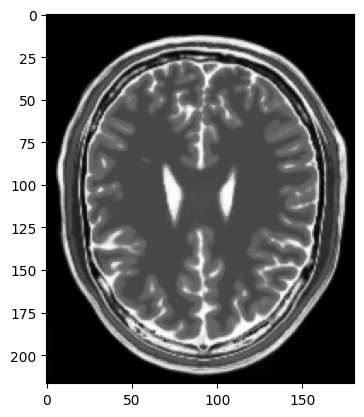

In [18]:
plt.imshow((a / a.max() * 255).astype(np.uint8), cmap="gray", vmin=0, vmax=255)

In [1]:
import os

if "script" in os.getcwd():
    os.chdir("..")
from src.model.dncnn import DnCNN
import numpy as np
import torch
from src.dataset.data_generator import DenoisingDataset, TestPhase

ImportError: cannot import name 'TestPhase' from 'src.dataset.data_generator' (e:\Thacsi\Master_Course\ImageDenoise\src\dataset\data_generator.py)

In [4]:
model = torch.load(r"result_/layers_DnCNN10/model_030.pth")
# model = DnCNN(channels=1, num_of_layers=17, features=192)
model.eval()
# test_phase = TestPhase(range_sigma =[0,80], step = 5, data_dir ='data', n_workers=0, batch_size=6, log_dir=f'result/test')

# test_phase.run(model,1)

DnCNN(
  (dncnn): Sequential(
    (0): Conv2d(1, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): ReLU(inplace=True)
    (2): Conv2d(192, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (3): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): ReLU(inplace=True)
    (5): Conv2d(192, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (6): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): ReLU(inplace=True)
    (8): Conv2d(192, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (9): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): Conv2d(192, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (12): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU(inplace=True)
    (14): Conv2d(192, 1

In [5]:
from torchvision import transforms


def read_npy(path: str):
    with open(path, "rb") as f:
        a = np.load(f)
        a = a / np.max(a) * 255
    return a


transform = transforms.ToTensor()

Max: 108.23607738758922, Min: -150.99888248007534
Max: 17.72755241394043, Min: -6.24906063079834
(1, 217, 181)
(1, 1, 217, 181)
PSNR: 16.271242444308918
PSNR: inf


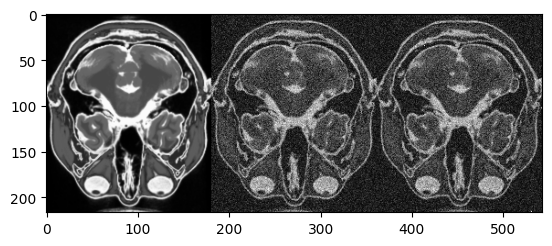

In [9]:
import matplotlib.pyplot as plt

sigma = 35
path = f"data/test/sigma_{sigma}/33synBrainT2.npy"

x = read_npy(path.replace(f"/sigma_{sigma}", "/origin"))
y = read_npy(path)
print(f"Max: {np.max(y-x)}, Min: {np.min(y-x)}")


noise_img = y.astype(np.uint8)

x = transform(x).float()
y = transform(y).float().clamp(min=0, max=255)


input_model = y
label = x
model.cuda()
predict = model(input_model.unsqueeze(0).cuda())

denoise_img = denoise_imgs = (
    (input_model.cuda() - predict).cpu().detach().numpy().astype(np.uint8)
)

predict_noise = predict.cpu().detach().numpy()
print(f"Max: {np.max(predict_noise)}, Min: {np.min(predict_noise)}")

label = label.cpu().detach().numpy().astype(np.uint8)
print(label.shape)
print(denoise_img.shape)

from skimage.metrics import peak_signal_noise_ratio

print(
    f"PSNR: {peak_signal_noise_ratio(label.squeeze(0), denoise_img.squeeze(0).squeeze(0))}"
)
print(f"PSNR: {peak_signal_noise_ratio(label.squeeze(0), label.squeeze(0))}")

plt.imshow(
    np.hstack((label.squeeze(0), noise_img, denoise_img.squeeze(0).squeeze(0))),
    cmap="gray",
)
plt.show()